# Spectral Fitting

This notebook measures aperiodic activity using various different spectral fitting measures.

There have been many variations for fitting power spectra. This notebook compares different strategies.

This notebooks covers:
- Linear fits to power spectra in log-log spacing, using a simple (OLS) linear fit
- Linear fits to power spectra in log-log spacing, using a robust (RLM) linear fit
- Linear fits to power spectra in log-log spacing, using the RANSAC robust fitting algorithm
- Exponential fits to power spectra in semi-log spacing, using a simple exponential fit

In addition, various studies have used simple heuristics to try and fit aperiodic activity while avoiding being biased by peaks. 

In this comparison, we include the following variations of the aforementioned methods:
- Fitting the entire frequency range 
- Using a predefined exclusion zone of the alpha oscillation (7-14 Hz)
- Using exclusing zones for all oscillatory peaks*

Finally, these fits are all compared to the 
[spectral parameterization](https://fooof-tools.github.io/)
algorithm.

*Note that this approach uses spectral parameterization to detect and exclude oscillatory regions.


ToDos:
- fix up error plots (setting size and using savefig)
- adjust parameters to sweep across (extend a bit)
- check SpecParam settings
- show more PSD simulations (in sims notebook)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.linear_model import RANSACRegressor
from scipy.stats.mstats import normaltest

from fooof import FOOOF
from fooof.core.funcs import expo_nk_function as expf
from fooof.sim import gen_power_spectrum, gen_group_power_spectra

In [3]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.fit import *
from apm.spectral import SpectralFits
from apm.plts import plot_psds, plot_psds_two, plot_psds_shades
from apm.plts.errors import violin_errors, boxplot_errors
from apm.plts.utils import color_red_or_green

from apm.utils import exclude_spectrum, print_results

from apm.core.db import APMDB
from apm.core.io import save_pickle, load_pickle

from apm.sim.peaks import *

## Settings

In [4]:
# Set up project database object
db = APMDB()

In [5]:
# Simulation settings
f_range = [3, 40]
off_val = 0
noise = 0.0

In [6]:
# Notebook Settings
SAVE_FIG = False
SAVE_DATA = False

## Spectral Fitting Methods

Here we demonstrate spectral fitting methods for measuring the aperiodic exponent by directly fitting power spectra.

The implementations of these methods are available in `apm/fit.py`.

### Example PSD

Load an example PSD, from eyes closed, resting state EEG data, extracted to the range of 3-40 Hz. 

In [7]:
# Load an example power spectrum to check fitting with
freqs = np.load('data/freqs.npy')
psd = np.load('data/psd.npy')

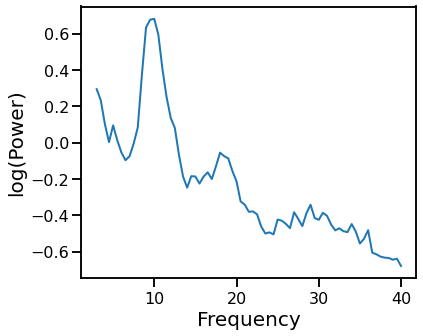

In [8]:
# Check a plot of the loaded power spectrum
plot_psds(freqs, psd)

## Methods for Fitting Power Spectra

Here, we introduce the various methods for fitting the aperiodic component of the power spectrum. 

In [9]:
# Initialize for collecting example fit results
example_results = {}

In [10]:
# Add constant for fitting with statsmodels
fx = sm.add_constant(np.log10(freqs))

### OLS Linear Fit

Fit a line in log-log with Ordinary Least Squares (OLS).

In [11]:
# Spectral fit: linear fit
ex_fit_ols = sm.OLS(np.log10(psd), fx).fit()
example_results['ols'] = ex_fit_ols.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_ols.fittedvalues)

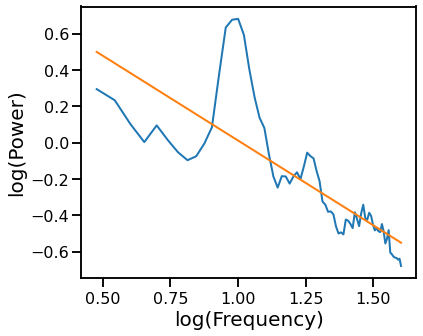

In [12]:
# Plot the aperiodic fit, from the OLS linear fit
plot_psds(freqs, [psd, pred_vals], log_freqs=True)

### Robust Fit with RLM

In [13]:
# Spectral fit: robust linear fit to log-log PSD
ex_fit_rlm = sm.RLM(np.log10(psd), fx).fit()
example_results['rlm'] = ex_fit_rlm.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_rlm.fittedvalues)

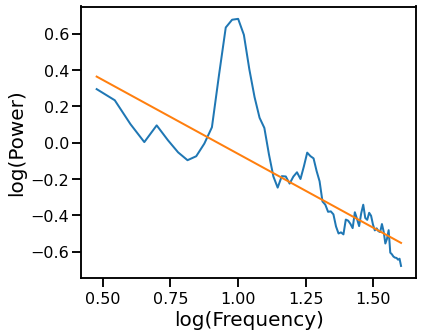

In [14]:
# Plot the aperiodic fit, from the robust linear fit
plot_psds(freqs, [psd, pred_vals], log_freqs=True)

### Robust Fit with RANSAC

In [15]:
# Reshape freqs for RANSAC fit
freqs_ran = freqs.reshape([len(freqs), 1])

In [16]:
# Initialize and fit with RANSAC
ex_ransac_model = RANSACRegressor()
ex_ransac_model.fit(np.log10(freqs_ran), np.log10(psd))
example_results['ran'] = ex_ransac_model.estimator_.coef_[0]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_ransac_model.predict(np.log10(freqs_ran)))

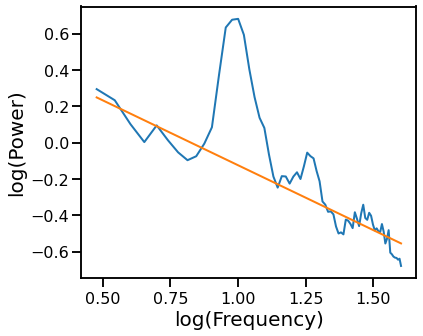

In [17]:
# Plot the aperiodic fit, from RANSAC
plot_psds(freqs_ran.flatten(), [psd, pred_vals], log_freqs=True)

## Spectral Fitting Excluding Alpha

Use a specific exclusion zone for the alpha oscillation.

In [18]:
# Exclude predefined alpha range
freqs_alph, psd_alph = exclude_spectrum(np.squeeze(freqs), psd, [7, 14])#, False)

# Reset freqs, with constant
fx_alph = sm.add_constant(np.log10(freqs_alph))

### Simple OLS Linear Fit Exlucing Generic Alpha Band

In [19]:
# Linear fit without alpha range
ex_fit_ols_alph = sm.OLS(np.log10(psd_alph), fx_alph).fit()
example_results['ols_alph'] = ex_fit_ols_alph.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_ols_alph.fittedvalues)

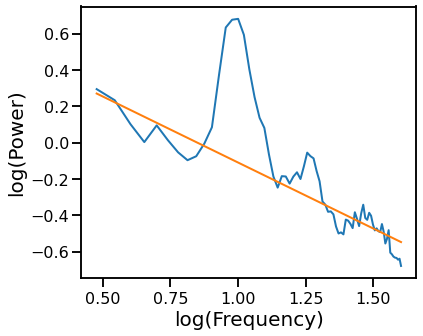

In [20]:
# Plot the aperiodic fit, from an OLS linear fit with an alpha exclusion zone
plot_psds([freqs, freqs_alph], [psd, pred_vals], log_freqs=True)

### Robust Fit with RLM Excluding Generic Alpha Band

In [21]:
# Robust fit without alpha range
ex_fit_rlm_alph = sm.RLM(np.log10(psd_alph), fx_alph).fit()
example_results['rlm_alph'] = ex_fit_rlm_alph.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_rlm_alph.fittedvalues)

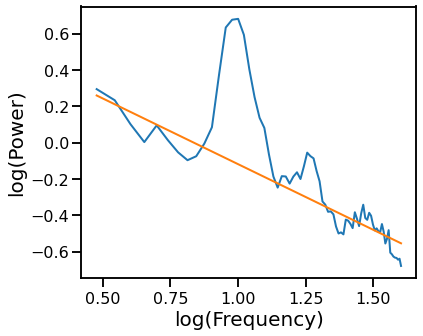

In [22]:
# Plot the aperiodic fit, from the robust linear fit with an alpha exclusion zone
plot_psds([freqs, freqs_alph], [psd, pred_vals], log_freqs=True)

### Robust Fit with RANSAC Excluding Generic Alpha Band

In [23]:
# Fit alpha-exclusion with RANSAC
ex_ransac_model_alph = RANSACRegressor()
ex_ransac_model_alph.fit(np.log10(freqs_alph), np.log10(psd_alph))
example_results['ran_alph'] = ex_ransac_model_alph.estimator_.coef_[0][0]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_ransac_model_alph.predict(np.log10(freqs_alph)))

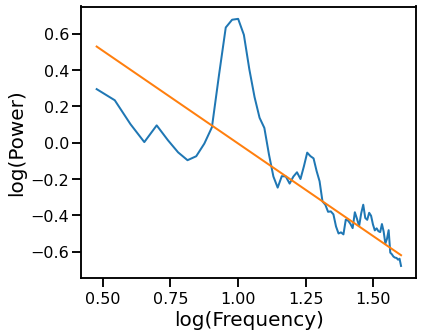

In [24]:
# Plot the aperiodic fit, from the RANSAC fit with alpha exclusion zone
plot_psds([freqs, freqs_alph], [psd, pred_vals], log_freqs=True)

## Spectral Fit Excluding Oscillations

Use a exclusion zones for oscillations.

In [25]:
# Fit spectral model for finding peaks
fm = FOOOF(peak_width_limits=[1, 8])
fm.fit(freqs, psd, [3, 40])

In [26]:
# Get oscillation definitions from FOOOF
cens = fm.gaussian_params_[:, 0]
bws = fm.gaussian_params_[:, 2]

# Define oscillation ranges, as a range around each center frequency
m = 2
osc_ranges = [[cen-m*bw, cen+m*bw] for cen, bw in zip(cens, bws)]

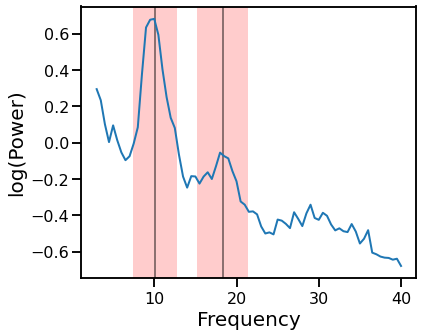

In [27]:
# Plot PSD with oscillatory regions shaded
plot_psds_shades(freqs, psd, osc_ranges)

In [28]:
# Exclude oscillation bands, as measured from FOOOF
psd_excl = psd
freqs_excl = np.squeeze(freqs)

for cen, bw in zip(cens, bws):
    freqs_excl, psd_excl = exclude_spectrum(freqs_excl, psd_excl, [cen-m*bw, cen+m*bw])

In [29]:
# Create a frequency vector with exlcusion zones for model fitting
fx_excl = sm.add_constant(np.log10(freqs_excl))

### Simple Linear Fit Excluding Oscillatory Bands

In [30]:
# Linear fit without alpha range
ex_fit_ols_excl = sm.OLS(np.log10(psd_excl), fx_excl).fit()
example_results['ols_excl'] = ex_fit_ols_excl.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_ols_excl.fittedvalues)

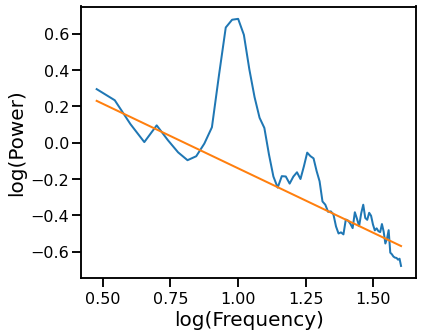

In [31]:
# Plot the aperiodic fit, from the OLS linear fit with oscillation exclusion zones
plot_psds([freqs, freqs_excl], [psd, pred_vals], log_freqs=True)

### Robust Fit with RLM Excluding Oscillatory Bands

In [32]:
# Robust fit without oscillation bands
ex_fit_rlm_excl = sm.RLM(np.log10(psd_excl), fx_excl).fit()
example_results['rlm_excl'] = ex_fit_rlm_excl.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_rlm_excl.fittedvalues)

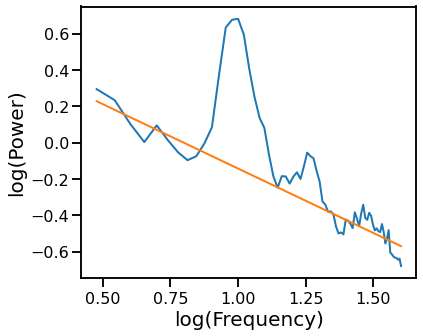

In [33]:
# Plot the aperiodic fit, from the robust linear fit with oscillation exclusion zones
plot_psds([freqs, freqs_excl], [psd, pred_vals], log_freqs=True)

### Robust Fit with RANSAC Excluding Oscillatory Bands

In [34]:
# Fit alpha-exclusion with RANSAC
ex_ransac_model_excl = RANSACRegressor()
ex_ransac_model_excl.fit(np.log10(freqs_excl), np.log10(psd_excl))
example_results['ran_excl'] = ex_ransac_model_excl.estimator_.coef_[0][0]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_ransac_model_excl.predict(np.log10(freqs_excl)))

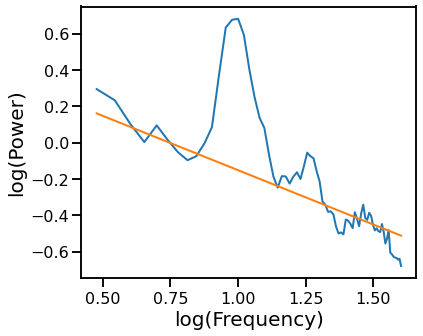

In [35]:
# Plot the aperiodic fit, from the RANSAC fit with oscillation exclusion zones
plot_psds([freqs, freqs_excl], [psd, pred_vals], log_freqs=True)

## Exponential Fits

### Exponential Fit

In [36]:
# Fit exponential 1/f, with scipy curve_fit
ex_fit_exp, _ = curve_fit(expf, np.squeeze(freqs), np.squeeze(np.log10(psd)), p0=[1, 1])
example_results['exp'] = -ex_fit_exp[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, expf(freqs, *ex_fit_exp))

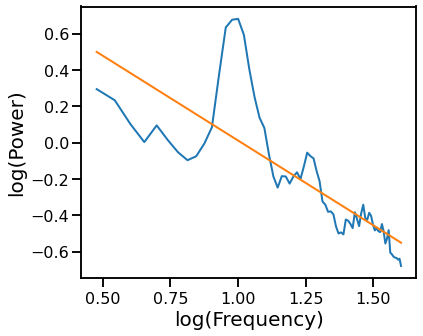

In [37]:
# Plot the aperiodic fit, from the exponential fit
plot_psds(freqs.flatten(), [psd, pred_vals], log_freqs=True)

### Exponential Fit Excluding Alpha Region

In [38]:
# Fit exponential 1/f, with scipy curve_fit, excluding alpha range
ex_fit_exp_alph, _ = curve_fit(expf, np.squeeze(freqs_alph), np.squeeze(np.log10(psd_alph)), p0=[1, 1])
example_results['exp_alph'] = -ex_fit_exp_alph[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, expf(freqs_alph, *ex_fit_exp_alph))

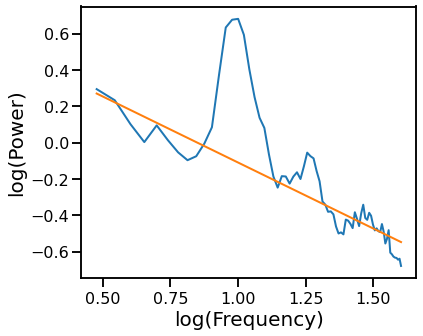

In [39]:
# Plot the aperiodic fit, from the exponential fit, with an alpha exclusion zone
plot_psds([freqs, freqs_alph], [psd, pred_vals], log_freqs=True)

### Exponential Fit Excluding Oscillation Regions

In [40]:
# Fit exponential 1/f, with scipy curve_fit, excluding oscillatory regions
ex_fit_exp_excl, _ = curve_fit(expf, np.squeeze(freqs_excl), np.squeeze(np.log10(psd_excl)), p0=[1, 1])
example_results['exp_excl'] = -ex_fit_exp_excl[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, expf(freqs_excl, *ex_fit_exp_excl))

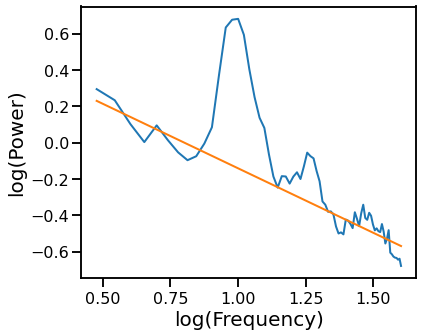

In [41]:
# Plot the aperiodic fit, from the exponential fit with oscillation exclusion zones
plot_psds([freqs, freqs_excl], [psd, pred_vals], log_freqs=True)

## Spectral Parameterization


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offs

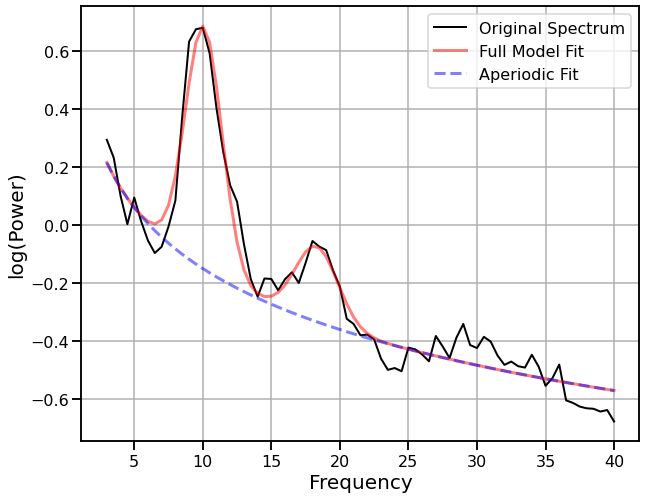

In [42]:
# Fit the SpecParam model
fm = FOOOF()
fm.report(freqs, psd, [3, 40])
example_results['fooof'] = -fm.aperiodic_params_[1]

## Compare Example Fits

In [42]:
# Print out results across all the different approaches
print('FIT RESULTS')
for key, val in example_results.items():
    print('  {:10s} \t {:1.3f}'.format(key, val))

FIT RESULTS
  ols        	 -0.933
  rlm        	 -0.813
  ran        	 -1.025
  ols_alph   	 -0.726
  rlm_alph   	 -0.723
  ran_alph   	 -0.710
  ols_excl   	 -0.710
  rlm_excl   	 -0.709
  ran_excl   	 -0.748
  exp        	 -0.933
  exp_alph   	 -0.726
  exp_excl   	 -0.710
  fooof      	 -0.700


In [43]:
# Check fits ordered by magnitude
for key, val  in dict(sorted(example_results.items(), key=lambda it: it[1])).items():
    print('{:10s} \t {:1.5f}'.format(key, val))

ran        	 -1.02478
ols        	 -0.93306
exp        	 -0.93306
rlm        	 -0.81338
ran_excl   	 -0.74777
exp_alph   	 -0.72646
ols_alph   	 -0.72646
rlm_alph   	 -0.72290
exp_excl   	 -0.70999
ols_excl   	 -0.70999
ran_alph   	 -0.70970
rlm_excl   	 -0.70878
fooof      	 -0.69973


## Simulation Tests

Now that we have introduced the different methods, we will systematically evaluatate them across simulated data.

In [44]:
# Initialize and set up for simulated data testing
fits = SpectralFits()

In [45]:
# Check the fitting functions being used
print(list(fits.fit_funcs.keys()))

['OLS', 'OLS-EA', 'OLS-EO', 'RLM', 'RLM-EA', 'RLM-EO', 'RAN', 'RAN-EA', 'RAN-EO', 'EXP', 'EXP-EA', 'EXP-EO', 'FOOOF']


## Check out PSD generation and test fitting

In [46]:
# Generate a single simulated test power spectrum
exp_val = 1
peak_gen = gen_peak_def()
peaks = next(peak_gen)

In [47]:
# Simulate an example power spectrum
freqs, psd = gen_power_spectrum(f_range, [off_val, exp_val], peaks, noise)

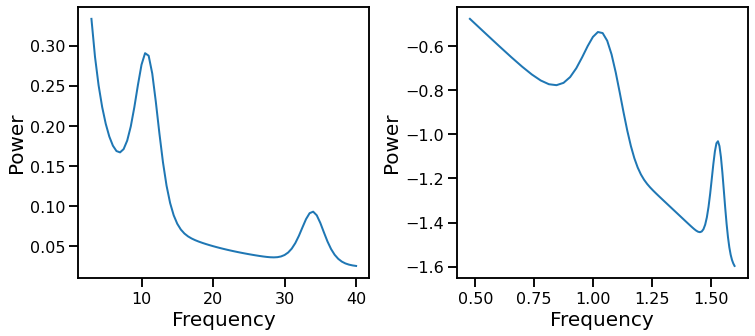

In [48]:
# Plot and check a simulated spectrum, plotted in semi-log and log space
plot_psds_two(freqs, psd, np.log10(freqs), np.log10(psd))

In [49]:
# Check example fits
print('Example fits for true exponent value of {:d}:'.format(exp_val))
for name, func in sims.fit_funcs.items():
    print('  {:5s} \t {:1.3f}'.format(name, func(freqs, psd)))

Example fits for true exponent value of 1:
  OLS   	 -0.957
  OLS-EA 	 -0.797
  OLS-EO 	 -0.997
  RLM   	 -0.957
  RLM-EA 	 -0.883
  RLM-EO 	 -0.998
  RAN   	 -0.981
  RAN-EA 	 -0.964
  RAN-EO 	 -0.997
  EXP   	 -0.957
  EXP-EA 	 -0.797
  EXP-EO 	 -0.997
  FOOOF 	 -0.995


## Run Spectral Fits on Simulated Power Spectra

Run spectral fitting across multiple exponents and noise levels.

In [66]:
# Spectrum Settings
N_SPECTRA = 150
F_RANGE = [3, 40]

# Simulation Settings
NOISE_VALS = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2]
EXP_VALS = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

#
VERBOSE = False

In [67]:
# Run all fits
all_fits = SpectralFits()
for exp in EXP_VALS:
    for noise in NOISE_VALS:

        if VERBOSE:
            print('Running sims for exponent val {}, noise-val {}'.format(exp, noise))

        # Simulate set of power spectra
        freqs, psds, sim_params = gen_group_power_spectra(\
            N_SPECTRA, F_RANGE, [off_val, exp], gen_peak_def(), noise, return_params=True)

        # Initialize SimFit object, and run fits
        fits = SpectralFits()
        fits.fit_spectra(exp, freqs, psds)
        
        # Collect results together
        all_fits = all_fits + fits

        # Save out fit data
        if SAVE_DATA:
            save_name = 'SpectralFits_exp' + str(exp) + '_N' + str(noise) + '.p'
            save_pickle(fits.errors, save_name, db.sims_path)

Running sims for exponent val 0.5, noise-val 0.0
Running sims for exponent val 0.5, noise-val 0.01
Running sims for exponent val 0.5, noise-val 0.05
Running sims for exponent val 0.5, noise-val 0.1
Running sims for exponent val 0.5, noise-val 0.15
Running sims for exponent val 0.5, noise-val 0.2
Running sims for exponent val 1.0, noise-val 0.0
Running sims for exponent val 1.0, noise-val 0.01
Running sims for exponent val 1.0, noise-val 0.05
Running sims for exponent val 1.0, noise-val 0.1
Running sims for exponent val 1.0, noise-val 0.15
Running sims for exponent val 1.0, noise-val 0.2
Running sims for exponent val 1.5, noise-val 0.0
Running sims for exponent val 1.5, noise-val 0.01
Running sims for exponent val 1.5, noise-val 0.05
Running sims for exponent val 1.5, noise-val 0.1
Running sims for exponent val 1.5, noise-val 0.15
Running sims for exponent val 1.5, noise-val 0.2
Running sims for exponent val 2.0, noise-val 0.0
Running sims for exponent val 2.0, noise-val 0.01
Running si

In [99]:
# Check available simulated fit results files
sim_files = db.check_files('sims')
sim_files

['SimFits_exp1.0_N0.0.p',
 'SimFits_exp0.5_N0.1.p',
 'SimFits_exp0.5_N0.15.p',
 'SimFits_exp0.5_N0.05.p',
 'SimFits_exp0.5_N0.01.p',
 'SimFits_test.p',
 'SimFits_exp0.5_N0.2.p',
 'SimFits_exp1.0_N0.1.p',
 'SimFits_exp1.0_N0.01.p',
 'SimFits_exp1.0_N0.05.p',
 'SimFits_exp0.5_N0.0.p']

In [ ]:
# # Load specific spectral fits
# f_ind = 0
# fits = SpectralFits()
# fits.errors = load_pickle(sim_files[f_ind], db.sims_path)

In [ ]:
# # Reload and combine all fit files
# all_fits = SpectralFits()

# for f_name in sim_files:
#     temp = SpectralFits()
#     temp.errors = load_pickle(f_name, db.sims_path)
#     all_fits = all_fits + temp

## Compare Spectral Fitting

In [70]:
# Check how many PSDs are included in simulated data model fits
print(len(all_fits))

5400


In [93]:
# Check the average errors per method
print('Average error for each method:')
print_results(all_fits.compute_avg_errors(avg='mean'))

Average Fit Errors:
   FOOOF    		 0.06508
   RLM-EO   		 0.06760
   RLM-EA   		 0.06773
   OLS-EO   		 0.07108
   EXP-EO   		 0.07108
   RLM      		 0.08187
   EXP-EA   		 0.08489
   OLS-EA   		 0.08489
   RAN      		 0.08988
   RAN-EO   		 0.09329
   OLS      		 0.11173
   EXP      		 0.11173
   RAN-EA   		 0.12120


In [72]:
# Check the standard deviation of errors per method
print('Standard deviation of the errors for each method:')
print_results(all_fits.compute_std_errors())

   FOOOF    		 0.09245
   RLM-EA   		 0.11745
   RLM      		 0.12289
   RAN      		 0.13073
   EXP-EA   		 0.13402
   OLS-EA   		 0.13402
   EXP      		 0.15000
   OLS      		 0.15000
   RAN-EA   		 0.25666
   RAN-EO   		 0.29717
   RLM-EO   		 0.38038
   OLS-EO   		 0.38099
   EXP-EO   		 0.38099


In [83]:
# Check the number of fits that pass a threshold, per method
print('Percentage of fits below an error threshold:')
print_results(all_fits.compute_threshold(thresh=0.05))

   RLM-EA   		 0.63796
   RLM-EO   		 0.63426
   OLS-EO   		 0.61704
   EXP-EO   		 0.61704
   FOOOF    		 0.60278
   RLM      		 0.57833
   RAN-EO   		 0.57685
   OLS-EA   		 0.55926
   EXP-EA   		 0.55926
   RAN-EA   		 0.54352
   RAN      		 0.52389
   OLS      		 0.46963
   EXP      		 0.46963


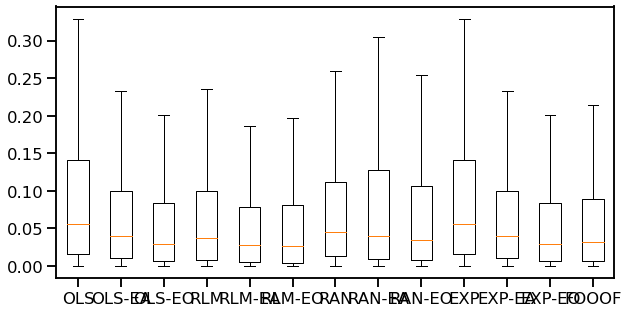

In [74]:
# Create boxplot of errors
boxplot_errors(all_fits.errors)

In [75]:
# Define labels
mains = ['OLS', 'RLM', 'RAN', 'EXP', 'FOOOF']
alphas = ['OLS-EA', 'RLM-EA', 'RAN-EA', 'EXP-EA', 'FOOOF']
oscs = ['OLS-EO', 'RLM-EO', 'RAN-EO', 'EXP-EO', 'FOOOF']

In [76]:
# Split up methods by approach
main_dicts = {label : all_fits.errors[label] for label in mains}
alphas_dicts = {label : all_fits.errors[label] for label in alphas}
oscs_dicts = {label : all_fits.errors[label] for label in oscs}

## Violin Plots

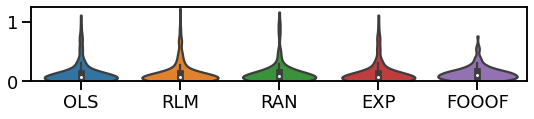

In [84]:
violin_errors(main_dicts, ylim=[0, 1.25])
if SAVE_FIG:
    plt.savefig(db.make_fig_name('SpectralFitting-Main', file_type='pdf')) 

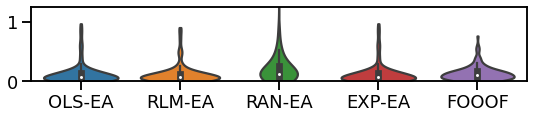

In [85]:
violin_errors(alphas_dicts, ylim=[0, 1.25])
if SAVE_FIG:
    plt.savefig(db.make_fig_name('SpectralFitting-EA', file_type='pdf'))

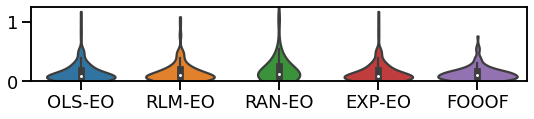

In [86]:
violin_errors(oscs_dicts, ylim = [0, 1.25])
if SAVE_FIG:
    plt.savefig(db.make_fig_name('SpectralFitting-EO', file_type='pdf'))

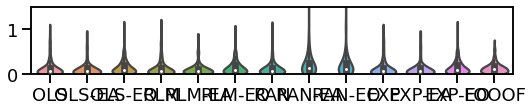

In [87]:
# Violin plot of error distributions
ax = violin_errors(all_fits.errors, ylim=[0, 1.5])
if SAVE_FIG:
    plt.savefig(db.make_fig_name('violin_plot', file_type='pdf'))

## Statistically Compare Methods

In [94]:
# Create a dataframe of the simulation errors
errors_df = pd.DataFrame(all_fits.errors)

In [95]:
# Check the correlation structure between fit errors
errors_df.corr()

,OLS,OLS-EA,OLS-EO,RLM,RLM-EA,RLM-EO,RAN,RAN-EA,RAN-EO,EXP,EXP-EA,EXP-EO,FOOOF
OLS,1.000000,0.818497,0.102132,0.921337,0.744152,0.079264,0.643602,0.207024,0.113246,1.000000,0.818497,0.102132,0.590402
OLS-EA,0.818497,1.000000,0.132820,0.799876,0.943851,0.106513,0.611408,0.273438,0.145354,0.818497,1.000000,0.132820,0.711181
OLS-EO,0.102132,0.132820,1.000000,0.118362,0.146041,0.997238,0.111890,0.055116,0.887001,0.102132,0.132820,1.000000,0.209637
RLM,0.921337,0.799876,0.118362,1.000000,0.802928,0.104369,0.712715,0.269595,0.155608,0.921337,0.799876,0.118362,0.659361
RLM-EA,0.744152,0.943851,0.146041,0.802928,1.000000,0.126315,0.625773,0.312012,0.176786,0.744152,0.943851,0.146041,0.758429
RLM-EO,0.079264,0.106513,0.997238,0.104369,0.126315,1.000000,0.102718,0.055033,0.890017,0.079264,0.106513,0.997238,0.187724
RAN,0.643602,0.611408,0.111890,0.712715,0.625773,0.102718,1.000000,0.279059,0.170636,0.643602,0.611408,0.111890,0.543077
RAN-EA,0.207024,0.273438,0.055116,0.269595,0.312012,0.055033,0.279059,1.000000,0.102929,0.207024,0.273438,0.055116,0.248329
RAN-EO,0.113246,0.145354,0.887001,0.155608,0.176786,0.890017,0.170636,0.102929,1.000000,0.113246,0.145354,0.887001,0.257650
EXP,1.000000,0.818497,0.102132,0.921337,0.744152,0.079264,0.643602,0.207024,0.113246,1.000000,0.818497,0.102132,0.590402


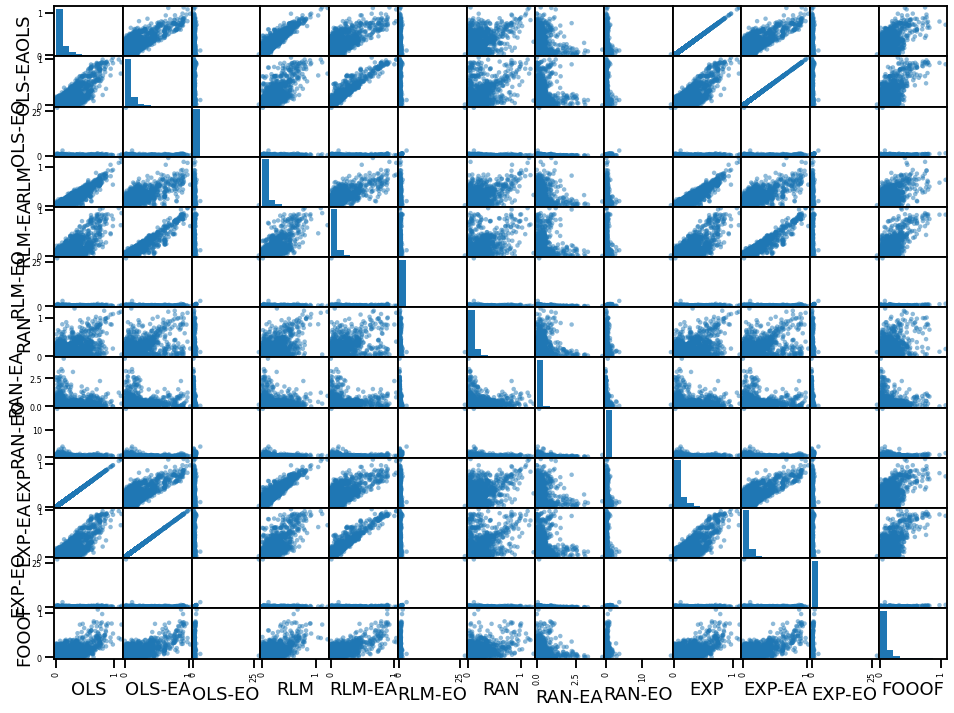

In [96]:
# Plot data distributions and inter-relations
pd.plotting.scatter_matrix(errors_df, figsize=[16, 12]);

In [97]:
# Apply a normal test across fit-error distributions
normalities = errors_df.apply(normaltest)

# Check which results of normal test
nt_df = pd.DataFrame([data[1] for data in normalities.values], index=normalities.index)
nt_df.style.applymap(color_red_or_green)

,0
OLS,0.000000
OLS-EA,0.000000
OLS-EO,0.000000
RLM,0.000000
RLM-EA,0.000000
RLM-EO,0.000000
RAN,0.000000
RAN-EA,0.000000
RAN-EO,0.000000
EXP,0.000000


In [81]:
# Run comparisons between methods
comps = all_fits.compare_errors()

In [82]:
# Print out color-coded dataframe of comparison results
comps_df = pd.DataFrame(comps, index=all_fits.errors.keys(), columns=all_fits.errors.keys())
comps_df.style.applymap(color_red_or_green)

,OLS,OLS-EA,OLS-EO,RLM,RLM-EA,RLM-EO,RAN,RAN-EA,RAN-EO,EXP,EXP-EA,EXP-EO,FOOOF
OLS,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.793064,0.000000,0.000000,0.000000
OLS-EA,0.000000,1.000000,0.000000,0.015930,0.000000,0.000000,0.000015,0.010118,0.010218,0.000000,0.793169,0.000000,0.000000
OLS-EO,0.000000,0.000000,1.000000,0.000000,0.002644,0.000003,0.000000,0.000000,0.000001,0.000000,0.000000,0.791911,0.697162
RLM,0.000000,0.015930,0.000000,1.000000,0.000000,0.000000,0.000000,0.000001,0.908650,0.000000,0.005522,0.000001,0.000003
RLM-EA,0.000000,0.000000,0.002644,0.000000,1.000000,0.109747,0.000000,0.000000,0.000000,0.000000,0.000000,0.001125,0.000617
RLM-EO,0.000000,0.000000,0.000003,0.000000,0.109747,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000000
RAN,0.000000,0.000015,0.000000,0.000000,0.000000,0.000000,1.000000,0.182246,0.000000,0.000000,0.000088,0.000000,0.000000
RAN-EA,0.000000,0.010118,0.000000,0.000001,0.000000,0.000000,0.182246,1.000000,0.000001,0.000000,0.017689,0.000000,0.000000
RAN-EO,0.000000,0.010218,0.000001,0.908650,0.000000,0.000000,0.000000,0.000001,1.000000,0.000000,0.003507,0.000002,0.000002
EXP,0.793064,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


## Conclusions

Words, words, words.